<a href="https://colab.research.google.com/github/Aryank47/machine_learning/blob/master/logistic_regression_with_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
df=load_iris(as_frame=True)
df=df.frame

In [ ]:
print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


In [ ]:
print(df.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)      target  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [ ]:
dup = df[df.duplicated()]
print("Number of duplicates:", len(dup))
df = df.drop_duplicates(keep="first")

Number of duplicates: 1


In [ ]:
print(df.skew(numeric_only=True))

sepal length (cm)    0.312826
sepal width (cm)     0.307149
petal length (cm)   -0.263101
petal width (cm)    -0.090076
target               0.012434
dtype: float64


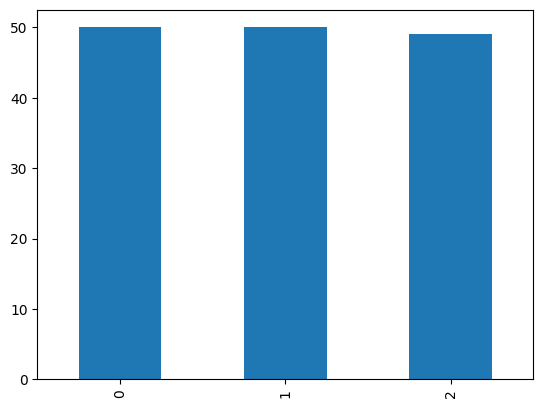

In [ ]:
df['target'].value_counts()
df['target'].value_counts().plot(kind='bar')
plt.show()

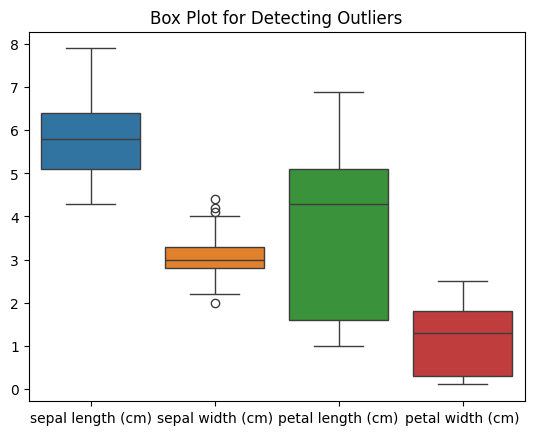

In [ ]:
# sns.set(rc={"figure.figsize":(12, 8)})
sns.boxplot(data=df[["sepal length (cm)", "sepal width (cm)",  "petal length (cm)","petal width (cm)"]])
plt.title('Box Plot for Detecting Outliers')
plt.show()

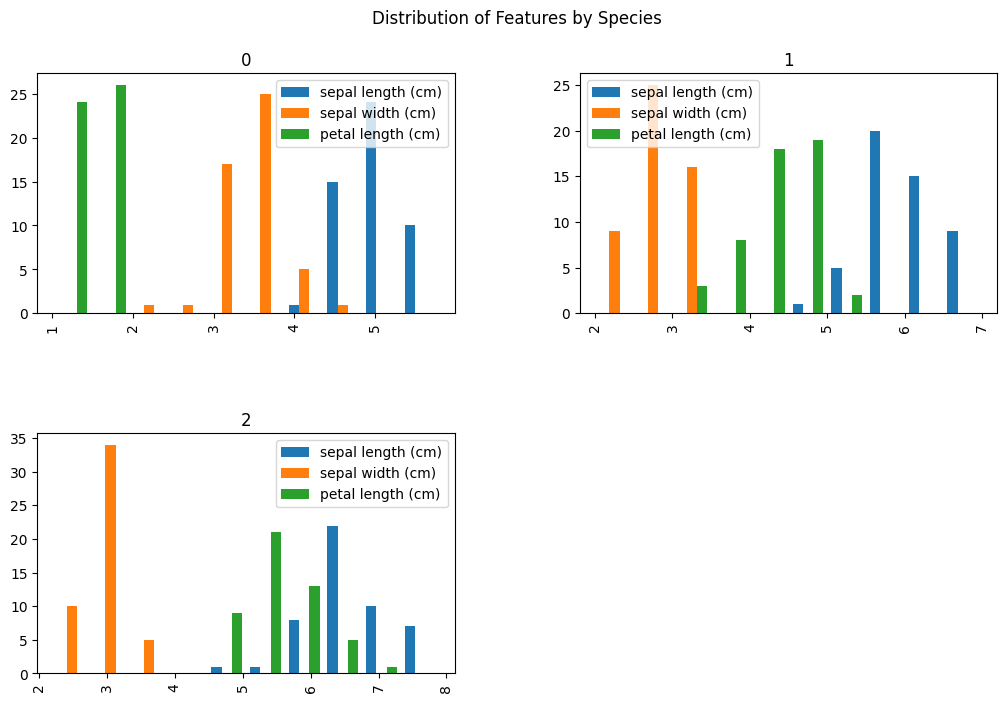

In [ ]:
df.hist(column=["sepal length (cm)" , "sepal width (cm)" , "petal length (cm)"], by='target', figsize=(12, 8),legend=True)
plt.suptitle('Distribution of Features by Species')
plt.show()

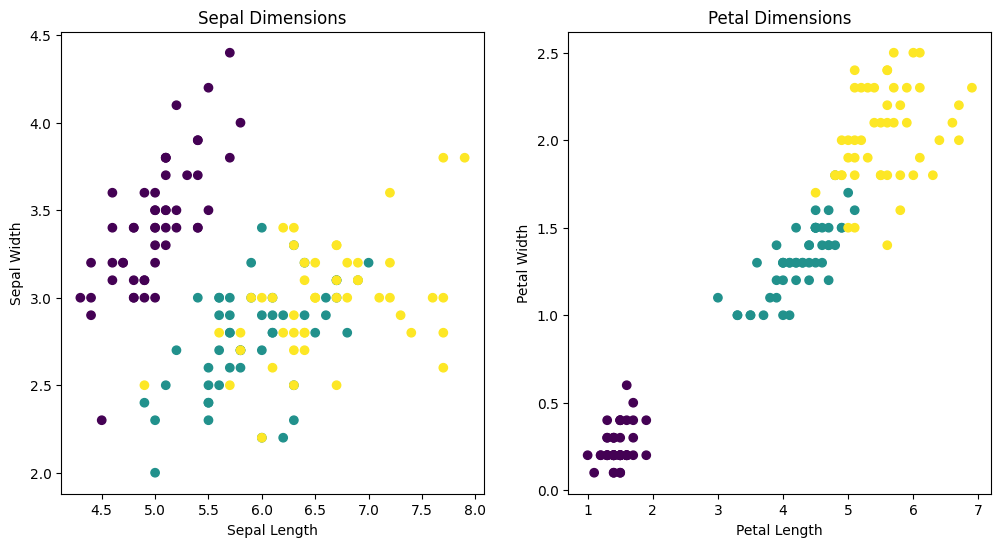

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df['sepal length (cm)'], df['sepal width (cm)'], c=pd.factorize(df['target'])[0], cmap='viridis')
plt.title('Sepal Dimensions')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

plt.subplot(1, 2, 2)
plt.scatter(df['petal length (cm)'], df['petal width (cm)'], c=pd.factorize(df['target'])[0], cmap='viridis')
plt.title('Petal Dimensions')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

plt.show()

In [ ]:

def calc_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)


def calc_precision_recall_confusion_matrix(y_true, y_pred, n_classes):
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for true, pred in zip(y_true, y_pred):
        confusion_matrix[true][pred] += 1
    precision = np.diag(confusion_matrix) / (np.sum(confusion_matrix, axis=0) + 1e-7)
    recall = np.diag(confusion_matrix) / (np.sum(confusion_matrix, axis=1) + 1e-7)
    return precision, recall, confusion_matrix


def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


def standardize_features(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std, mean, std


def apply_standardization(X, mean, std):
    return (X - mean) / std


def calc_f1_score(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=200):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.best_weights = None
        self.best_bias = None
        self.best_epochh = -1
        self.best_val_accuracy = -1
        self.history = {'loss': [], 'val_loss': [], 'val_accuracy': [],'test_loss':[],'test_accuracy':[]}

    def softmax(self, logits):
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def negative_log_likelihood(self, y_true, probabilities):
        one_hot_y = np.eye(probabilities.shape[1])[y_true]
        return -np.sum(np.log(probabilities) * one_hot_y) / y_true.shape[0]

    def get_logits_and_probabilities(self, X):
        logits = np.dot(X, self.weights) + self.bias
        probabilities = self.softmax(logits)
        return logits, probabilities

    def get_loss_and_accuracy(self, X, y):
        logits, probabilities = self.get_logits_and_probabilities(X)
        loss = self.negative_log_likelihood(y, probabilities)
        predictions = np.argmax(probabilities, axis=1)
        accuracy = np.sum(predictions == y) / len(y)
        return loss, accuracy

    def fit(self, X_train, y_train, X_val, y_val,X_test,y_test, early_stopping_rounds=10):
        n_samples, n_features = X_train.shape
        n_classes = len(np.unique(y_train))
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)
        val_losses=[]
        val_accuracies=[]

        for epoch in range(self.epochs):
            logits, probablities = self.get_logits_and_probabilities(X_train)
            train_loss, train_accuracy = self.get_loss_and_accuracy(X_train, y_train)
            self.history['loss'].append(train_loss)


            one_hot_y = np.eye(n_classes)[y_train]
            gradient_w = np.dot(X_train.T, (probablities - one_hot_y)) / n_samples
            gradient_b = np.sum(probablities - one_hot_y, axis=0) / n_samples

            self.weights -= self.learning_rate * gradient_w
            self.bias -= self.learning_rate * gradient_b

            #validation data metric calculation
            val_loss, val_accuracy = self.get_loss_and_accuracy(X_val, y_val)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_accuracy)
            val_losses.append(round(val_loss,2))

            #test data metric calculation
            test_loss, test_accuracy = self.get_loss_and_accuracy(X_test, y_test)
            self.history['test_loss'].append(test_loss)
            self.history['test_accuracy'].append(test_accuracy)

            #update best val_acc,best_weights,best_bias
            if val_accuracy > self.best_val_accuracy:
                self.best_val_accuracy = val_accuracy
                self.best_weights = self.weights.copy()
                self.best_bias = self.bias.copy()
                self.best_epoch = epoch

            #applying early stopping
            if (
                len(val_losses) > early_stopping_rounds
                and val_losses[-1] == val_losses[-early_stopping_rounds]
            ):
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

            print(f"Epoch {epoch + 1}, Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    def predict(self, X):
        logits = np.dot(X, self.best_weights) + self.best_bias
        probabilities = self.softmax(logits)
        return np.argmax(probabilities, axis=1)

    def plot_losses_per_epoch(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.plot(self.history['test_loss'], label='Test Loss')
        plt.title('Loss per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def show_best_model_based_on_val_accuracy(self):
        self.weights = self.best_weights
        self.bias = self.best_bias
        print(f"Best model restored from epoch {self.best_epoch + 1} with Validation Accuracy: {self.best_val_accuracy}")

In [ ]:
X, y = iris.data, iris.target

In [ ]:
learning_rate=0.09
epochs=200
early_stopping_rounds=10

In [ ]:
model = LogisticRegression(learning_rate=learning_rate,epochs=epochs)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
X_train_scaled, mean, std = standardize_features(X_train)
X_val_scaled = apply_standardization(X_val, mean, std)
X_test_scaled = apply_standardization(X_test, mean, std)

In [ ]:
losses = model.fit(X_train=X_train_scaled, y_train=y_train, X_val=X_val_scaled, y_val=y_val, X_test=X_test_scaled, y_test=y_test, early_stopping_rounds=early_stopping_rounds)

Epoch 1, Loss: 1.0986122886681098, Val Loss: 0.9845270262186031, Val Accuracy: 0.7777777777777778, Test Loss: 0.9795774977741512, Test Accuracy: 0.7333333333333333
Epoch 2, Loss: 0.9811732144275732, Val Loss: 0.8960959422775043, Val Accuracy: 0.7777777777777778, Test Loss: 0.8880447022598309, Test Accuracy: 0.7333333333333333
Epoch 3, Loss: 0.8905211816602815, Val Loss: 0.827040864676145, Val Accuracy: 0.7777777777777778, Test Loss: 0.817078787111143, Test Accuracy: 0.7333333333333333
Epoch 4, Loss: 0.8201197334209938, Val Loss: 0.7723736493595114, Val Accuracy: 0.8148148148148148, Test Loss: 0.7612354607841083, Test Accuracy: 0.7333333333333333
Epoch 5, Loss: 0.7647412628177924, Val Loss: 0.7283643634104733, Val Accuracy: 0.8518518518518519, Test Loss: 0.7164862379570612, Test Accuracy: 0.7333333333333333
Epoch 6, Loss: 0.7204642235207394, Val Loss: 0.6923073340035095, Val Accuracy: 0.8888888888888888, Test Loss: 0.6799343824113417, Test Accuracy: 0.8
Epoch 7, Loss: 0.6844410896101286

In [ ]:
# Evaluate the model
classes=np.unique(y_train)
classes_count=len(np.unique(y_train))
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)
val_accuracy = calc_accuracy(y_val, y_val_pred)
test_accuracy = calc_accuracy(y_test, y_test_pred)
precision_val, recall_val, confusion_matrix_val = calc_precision_recall_confusion_matrix(y_val, y_val_pred, classes_count)
precision_test, recall_test, confusion_matrix_test = calc_precision_recall_confusion_matrix(y_test, y_test_pred, classes_count)
f1 = calc_f1_score(precision_test, recall_test)
macro_f1 = np.mean(f1)

# best model
model.show_best_model_based_on_val_accuracy()


# Display results
print(f"Validation Accuracy: {val_accuracy}\nTest Accuracy: {test_accuracy}")
print(f"Validation Precision: {precision_val}\nValidation Recall: {recall_val}")
print(f"Test Precision: {precision_test}\nTest Recall: {recall_test}")
print(f"F1: {f1}\nmacro F1: {macro_f1}")
print("Validation Confusion Matrix:")
print(confusion_matrix_val)
print("Test Confusion Matrix:")
print(confusion_matrix_test)

Best model restored from epoch 65 with Validation Accuracy: 0.9259259259259259
Validation Accuracy: 0.9259259259259259
Test Accuracy: 0.9333333333333333
Validation Precision: [0.99999999 0.99999999 0.83333333]
Validation Recall: [0.99999999 0.77777777 0.99999999]
Test Precision: [0.99999998 0.99999998 0.74999998]
Test Recall: [0.99999998 0.83333332 0.99999997]
F1: [0.99999993 0.90909084 0.85714278]
macro F1: 0.9220778533273396
Validation Confusion Matrix:
[[ 8  0  0]
 [ 0  7  2]
 [ 0  0 10]]
Test Confusion Matrix:
[[6 0 0]
 [0 5 1]
 [0 0 3]]


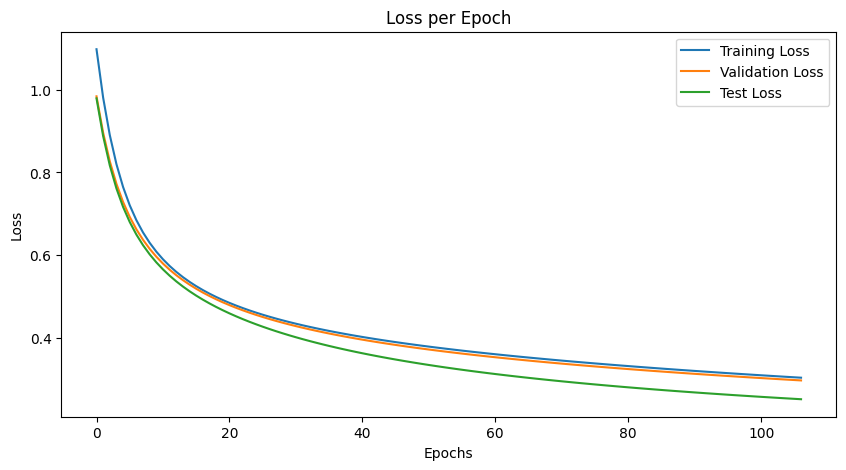

In [ ]:
model.plot_losses_per_epoch()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


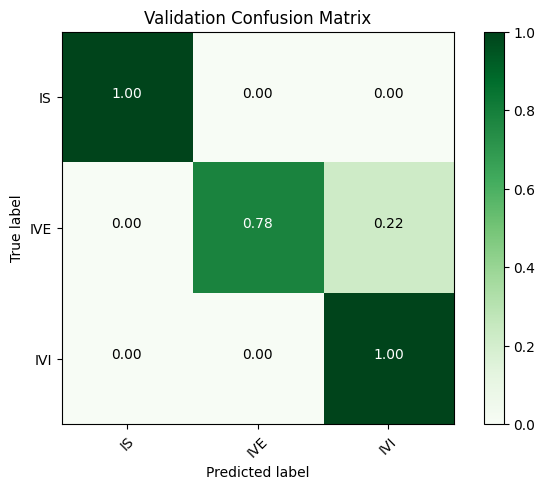

In [ ]:
['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
class_name=["IS","IVE","IVI"]
plot_confusion_matrix(confusion_matrix_val, class_name, normalize=True, title='Validation Confusion Matrix')


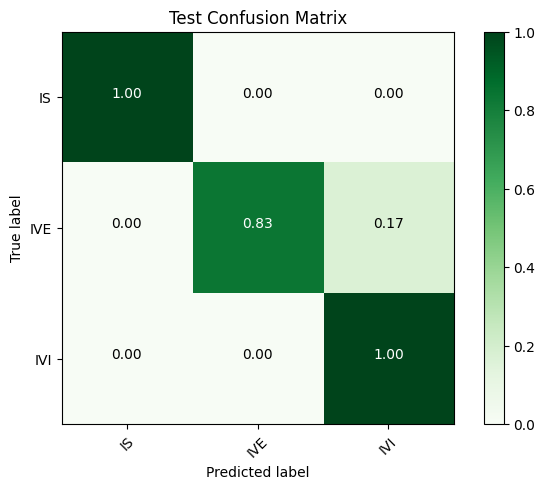

In [ ]:
plot_confusion_matrix(confusion_matrix_test, class_name, normalize=True, title='Test Confusion Matrix')